# Predicting the outcome of loan applications
# 4. Model comparison

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import sys
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import StratifiedKFold

p = os.path.abspath('../')
if p not in sys.path:
    sys.path.append(p)

from shared.data_processing import CategoricalEncoder
from shared.data_processing import FeatureSelector


## Load data

In [3]:
df = pd.read_csv('./data/loan_data_prepped.csv')

In [4]:
X = df.drop(['label', 'accepted'], axis=1)
y = df['label']

## Set the features
Features of interest we have identified in the previous notebooks.

In [5]:
NUMERICAL_FEATURES = ['duration', 'loan_amount', 'age']

FIXED_CATEGORICAL = ['foreign_worker_binary', 'checking_status_ordinal', 'savings_status_ordinal',
                     'employment_ordinal', 'installment_commitment_ordinal']

OTHER_CATEGORICAL = ['loan_history', 'purpose', 'other_parties', 'property_magnitude',
                     'other_payment_plans', 'housing', 'personal_status', 'job']

FEATURES = NUMERICAL_FEATURES + FIXED_CATEGORICAL + OTHER_CATEGORICAL

## Precision-recall curve

In [175]:
def compute_precision_recall_curve(X, y, pipeline, splitter, thresholds=np.arange(0, 1, 0.05)):
    """
    Compute average precision-recall curve over random train/test splits.
    
    Parameters
    ----------
    X: pandas.DataFrame
        Features to use for model training and testing.
    y: pandas.Series
        Labels to use for model training and testing.
    classifier: sklearn.linear_model.LogisticRegression or other
        Sklearn classifier that supports prediction of class proabilities.
    splitter: sklearn.model_selection.StratifiedShuffleSplit or similar
        Iterable object that generates random train/test splits.
    scaler: sklearn.preprocessing.StandardScaler or similar.
        Object that scales the features.
    oversampler: imblearn.over_sampling.ADASYN or similar.
        Object that generates synthetic data.
    threshold: np.array
        The threshold values to use for the calculation.
    
    Returns
    -------
    precisions: np.array
        Mean of precision scores by threshold over the splits.
    recalls: np.array
        Mean of recall scores by threshold over the splits.

    """
    precisions = np.zeros((splitter.n_splits, len(thresholds)))
    recalls = np.zeros((splitter.n_splits, len(thresholds)))

    for (i, (train_IDX, test_IDX)) in enumerate(splitter.split(X, y)):
        X_train = X.loc[train_IDX]
        y_train = y.loc[train_IDX]
        
        pipeline.fit(X_train, y_train)
        
        for j, threshold in enumerate(thresholds):
            X_test = X.loc[test_IDX]
            y_test = y.loc[test_IDX]
            predictions = (pipeline.predict_proba(X_test)[:,1] > threshold).astype(int)
            precisions[i,j] = precision_score(y_test, predictions, zero_division=1)
            recalls[i,j] = recall_score(y_test, predictions)
    
    return np.mean(precisions, axis=0), np.mean(recalls, axis=0)

In [176]:
def precision_recall_curve_random(X, y, splitter, thresholds=np.arange(0, 1, 0.05)):
    precisions = np.zeros((splitter.n_splits, len(thresholds)))
    recalls = np.zeros((splitter.n_splits, len(thresholds)))

    for (i, (train_IDX, test_IDX)) in enumerate(splitter.split(X, y)):
        for j, threshold in enumerate(thresholds):
            y_test = y.loc[test_IDX]
            predictions = (np.random.rand(len(y_test)) > threshold).astype(int)
            precisions[i,j] = precision_score(y_test, predictions, zero_division=0)
            recalls[i,j] = recall_score(y_test, predictions)
    return np.mean(precisions, axis=0), np.mean(recalls, axis=0)

In [177]:
IDX = [i for i in sss.split(X, y)][0][1]

In [178]:
y[IDX]

974    0.0
235    1.0
657    0.0
853    1.0
82     0.0
      ... 
342    0.0
813    1.0
147    0.0
668    1.0
415    0.0
Name: label, Length: 250, dtype: float64

In [179]:
predictions = (np.random.rand(len(y[IDX])) > 0.95).astype(int)

In [180]:
np.mean(predictions)

0.04

In [181]:
precision_score(y[IDX], predictions, zero_division=0)

0.4

In [182]:
recall_score(y[IDX], predictions)

0.05333333333333334

In [183]:
precisions_rand, recalls_rand = precision_recall_curve_random(X, y, sss)

In [184]:
precisions_rand

array([0.3       , 0.30004652, 0.30072812, 0.29897954, 0.30080683,
       0.30066775, 0.30416258, 0.30260928, 0.30051854, 0.29959159,
       0.29809589, 0.30693371, 0.29458635, 0.3032391 , 0.30093213,
       0.30714692, 0.30379636, 0.28651796, 0.29242374, 0.2878013 ])

## Set up the modelling pipelines to compare

In [185]:
encoder = CategoricalEncoder(features_to_encode=OTHER_CATEGORICAL)

In [186]:
selector = FeatureSelector(features_to_select=NUMERICAL_FEATURES + FIXED_CATEGORICAL)

In [187]:
logistic_tuned = LogisticRegression(max_iter=2000,
                                    class_weight='balanced',
                                    solver='lbfgs',
                                    C=1)

In [188]:
pipe_logistic = Pipeline(steps=[('encoder', encoder),
                                ('select', selector),
                                ('scaler', StandardScaler()),
                                ('logistic', logistic_tuned)])

In [189]:
rfc_tuned = RandomForestClassifier(class_weight='balanced',
                                   n_estimators=100,
                                   criterion='gini',
                                   max_depth=None,
                                   max_features='auto')

In [190]:
pipe_forest = Pipeline(steps=[('encode', encoder),
                              ('select', selector),
                              ('forest', rfc_tuned)])

In [191]:
np.arange(0, 1.05, 0.05)

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])

## Compute precision-recall curves

In [192]:
sss = StratifiedShuffleSplit(n_splits=50, test_size=0.25)

In [193]:
precisions_rfc, recalls_rfc = compute_precision_recall_curve(X, y, pipe_forest, sss)

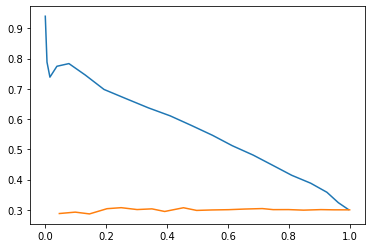

In [194]:
plt.plot(recalls_rfc, precisions_rfc)
plt.plot(recalls_rand, precisions_rand)

In [195]:
precisions_lr, recalls_lr = compute_precision_recall_curve(X, y, pipe_logistic, sss)

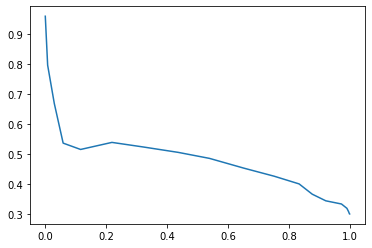

In [196]:
plt.plot(recalls_lr, precisions_lr)

## Compare the curves

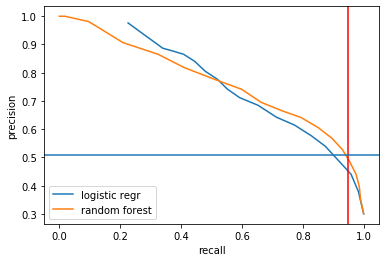

In [75]:
fig = plt.figure()
plt.plot(recalls_lr, precisions_lr)
plt.plot(recalls_rfc, precisions_rfc)
plt.xlabel('recall')
plt.ylabel('precision')
plt.axvline(0.95, color='red')
plt.axhline(0.51)
plt.legend(['logistic regr', 'random forest'])

In [53]:
pipe_logistic.fit(X, y)

Pipeline(steps=[('encoder',
                 CategoricalEncoder(features_to_encode=['loan_history',
                                                        'purpose',
                                                        'other_parties',
                                                        'property_magnitude',
                                                        'other_payment_plans',
                                                        'housing',
                                                        'personal_status',
                                                        'job'])),
                ('select',
                 FeatureSelector(features_to_select=['duration', 'loan_amount',
                                                     'age',
                                                     'foreign_worker_binary',
                                                     'checking_status_ordinal',
                                                     'savings_status_o

In [59]:
predictions = (pipe_logistic.predict_proba(X)[:,1] > 0.5).astype(int)

In [61]:
precision_score(y, predictions)

0.5035799522673031

In [62]:
recall_score(y,predictions)

0.7033333333333334